In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [2]:
# Parameters
epochs = 20
img_width, img_height = 224, 224
batch_size = 2
num_classes = 5
validation_split = 0.2
test_split = 0.1
data_dir = './../../datasets/dataset1'
learning_rate = 3.9e-5
 


# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split + test_split
)

# Augmentation parameters for specific classes
specific_class_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split + test_split
)

# Generators for training and validation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split / (validation_split + test_split)
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data preparation for testing
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=test_split / (validation_split + test_split)
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Oversampling the specified minority classes with augmentation
specific_classes = ['1', '2', '3', '4']  # Example specific class indices as strings
oversample_ratio = 2  # How many times to oversample the specific classes

# Create separate generators for the specific classes with augmentation
specific_class_generators = []
for cls in specific_classes:
    specific_class_generator = specific_class_augmentation.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        classes=[cls],
        subset='training',
        shuffle=True
    )
    specific_class_generators.append(specific_class_generator)

# Function to combine generators
def combined_generator(base_generator, specific_class_generators, oversample_ratio):
    while True:
        x_batch, y_batch = base_generator.next()
        for _ in range(oversample_ratio):
            specific_class_index = np.random.randint(len(specific_class_generators))
            x_specific, y_specific = specific_class_generators[specific_class_index].next()
            
            # Ensure y_specific matches the shape of y_batch
            if y_specific.shape[1] == 1:
                y_specific = np.eye(num_classes)[y_specific[:, 0].astype(int)]
                
            x_batch = np.concatenate((x_batch, x_specific), axis=0)
            y_batch = np.concatenate((y_batch, y_specific), axis=0)
        
        yield x_batch, y_batch

# Combined generator for training
combined_train_generator = combined_generator(train_generator, specific_class_generators, oversample_ratio)



Found 24591 images belonging to 5 classes.
Found 23416 images belonging to 5 classes.
Found 11708 images belonging to 5 classes.
Found 1711 images belonging to 1 classes.
Found 3705 images belonging to 1 classes.
Found 612 images belonging to 1 classes.
Found 496 images belonging to 1 classes.


In [3]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

In [4]:
metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [5]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, list(test_generator.class_indices.keys()))
    

In [6]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

74836368/74836368 [==============================] - 3s 0us/step


In [7]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    batch_size=128
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1/conv[0][0]']             
                                )                                                                 
          

train_accuracy->  [0.8932420611381531, 0.9056869745254517, 0.9096307158470154, 0.9113807082176208, 0.9133464097976685, 0.9150534272193909, 0.9163955450057983, 0.9163966774940491, 0.918159008026123, 0.9196627140045166, 0.920043408870697, 0.9206387996673584, 0.922889232635498, 0.9234054088592529, 0.9251948595046997, 0.9261835217475891, 0.9276883006095886, 0.9276350736618042, 0.9294913411140442, 0.9302921295166016]
val_accuracy->  [0.7338144779205322, 0.7287324666976929, 0.7432097792625427, 0.7407755255699158, 0.7451315522193909, 0.7432524561882019, 0.7543132901191711, 0.7487615346908569, 0.7586265802383423, 0.7507259845733643, 0.7564058899879456, 0.7635804414749146, 0.7603775262832642, 0.759608805179596, 0.7365476489067078, 0.7690467834472656, 0.7716518640518188, 0.7687051296234131, 0.77229243516922, 0.7783139944076538]
train_loss->  [0.33779728412628174, 0.2895040810108185, 0.27565523982048035, 0.2668040096759796, 0.2591916024684906, 0.2531166076660156, 0.24807529151439667, 0.2429734915

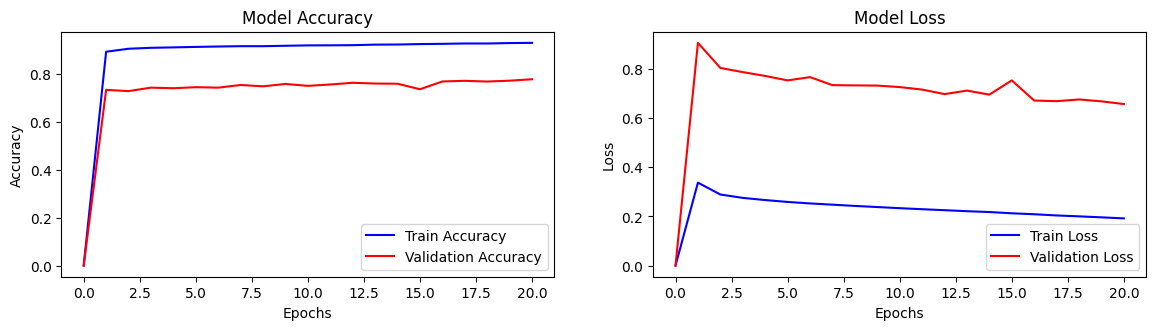

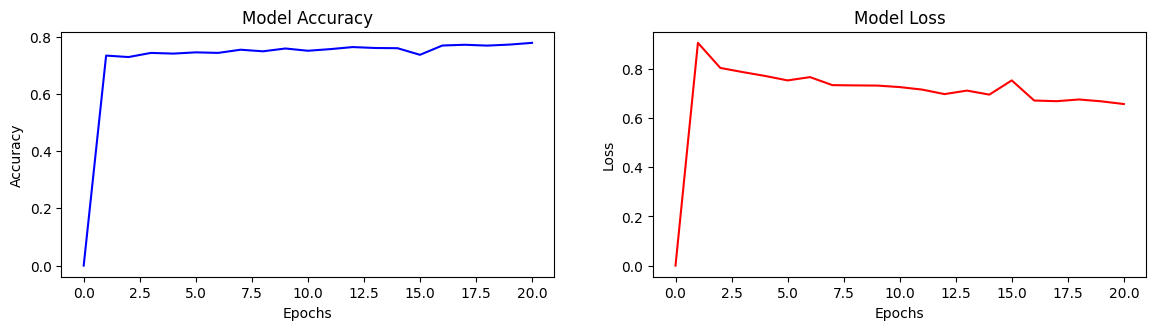

In [8]:
accuracyGraph(history)

5854/5854 [==============================] - 152s 26ms/step
              precision    recall  f1-score   support

           0       0.74      0.91      0.81      8603
           1       0.06      0.01      0.02       814
           2       0.16      0.05      0.08      1764
           3       0.03      0.02      0.03       291
           4       0.01      0.00      0.01       236

    accuracy                           0.68     11708
   macro avg       0.20      0.20      0.19     11708
weighted avg       0.57      0.68      0.61     11708

[[7846  130  385  136  106]
 [ 737   10   41   11   15]
 [1609   20   88   27   20]
 [ 255    4   21    6    5]
 [ 212    3   16    4    1]]


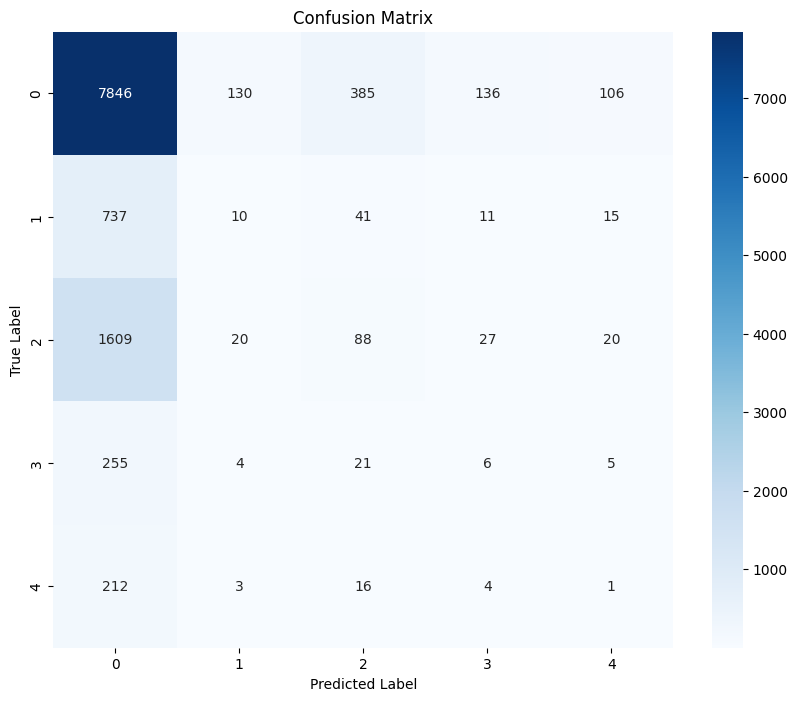

In [9]:
show_confusion_matrix(model)

In [10]:
_metrices = model.evaluate(test_generator)
print("Test Metrices", _metrices)

5854/5854 [==============================] - 162s 28ms/step - loss: 0.7796 - accuracy: 0.7511 - auc: 0.9228 - balanced_accuracy: 0.7511 - fscore: 0.6886 - precision: 0.7770 - recall: 0.7175
Test Metrices [0.7795692086219788, 0.7511103749275208, 0.9228256940841675, 0.7511103749275208, 0.6886343955993652, 0.7770070433616638, 0.7175435423851013]


In [11]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in model.layers[:379]:   
    layer.trainable = False
for layer in model.layers[379:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

Epoch 1/20


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12296/12296 [==============================] - 1166s 94ms/step - loss: 0.2660 - accuracy: 0.9125 - auc: 0.9845 - balanced_accuracy: 0.8587 - fscore: 0.8024 - precision: 0.9074 - recall: 0.8753 - val_loss: 0.7558 - val_accuracy: 0.7576 - val_auc: 0.9285 - val_balanced_accuracy: 0.7576 - val_fscore: 0.6964 - val_precision: 0.7744 - val_recall: 0.7377
Epoch 2/20
12296/12296 [==============================] - 1144s 93ms/step - loss: 0.2376 - accuracy: 0.9204 - auc: 0.9921 - balanced_accuracy: 0.8745 - fscore: 0.8188 - precision: 0.9330 - recall: 0.9077 - val_loss: 0.6680 - val_accuracy: 0.7769 - val_auc: 0.9407 - val_balanced_accuracy: 0.7769 - val_fscore: 0.7194 - val_precision: 0.8126 - val_recall: 0.7240
Epoch 3/20
12296/12296 [==============================] - 1148s 93ms/step - loss: 0.2223 - accuracy: 0.9246 - auc: 0.9931 - balanced_accuracy: 0.8835 - fscore: 0.8286 - precision: 0.9364 - recall: 0.9145 - val_loss: 0.6295 - val_accuracy: 0.7910 - val_auc: 0.9465 - val_balanced_accuracy

train_accuracy->  [0.9124640822410583, 0.9203958511352539, 0.924624502658844, 0.9303598999977112, 0.9354292154312134, 0.943211555480957, 0.95045006275177, 0.9577441811561584, 0.9659047722816467, 0.9718158841133118, 0.9774415493011475, 0.9822137951850891, 0.9844777584075928, 0.9868363738059998, 0.9881515502929688, 0.9895613193511963, 0.9900086522102356, 0.9915271401405334, 0.9914864897727966, 0.9924759864807129]
val_accuracy->  [0.7576443552970886, 0.7769473791122437, 0.7909976243972778, 0.7682781219482422, 0.8122650980949402, 0.8186283111572266, 0.8219593167304993, 0.8389562964439392, 0.8549709320068359, 0.8583447337150574, 0.8612487316131592, 0.8706012964248657, 0.8568500280380249, 0.8647506237030029, 0.8650922179222107, 0.8706867098808289, 0.8501024842262268, 0.8517680168151855, 0.8775623440742493, 0.87982577085495]
train_loss->  [0.2659546434879303, 0.23755693435668945, 0.22227853536605835, 0.2065618932247162, 0.1881837695837021, 0.1654168665409088, 0.14289143681526184, 0.1183555349

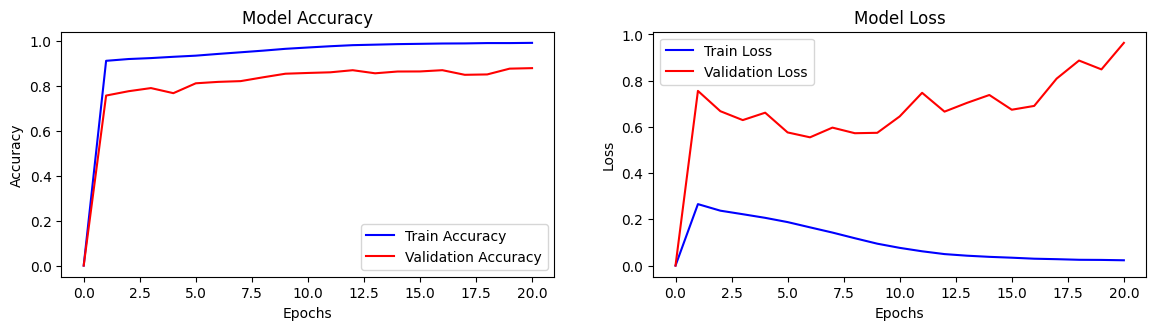

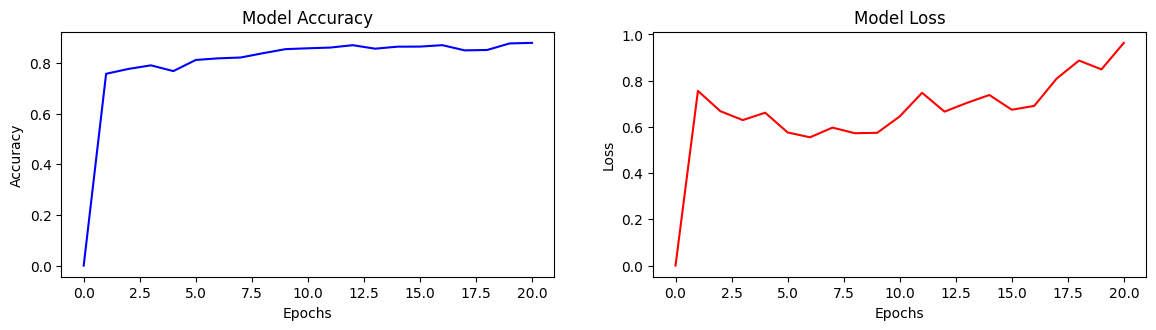

In [12]:
accuracyGraph(history)

5854/5854 [==============================] - 148s 25ms/step
              precision    recall  f1-score   support

           0       0.74      0.86      0.79      8603
           1       0.07      0.01      0.02       814
           2       0.17      0.10      0.13      1764
           3       0.01      0.01      0.01       291
           4       0.01      0.02      0.02       236

    accuracy                           0.65     11708
   macro avg       0.20      0.20      0.19     11708
weighted avg       0.57      0.65      0.60     11708

[[7386  121  765  142  189]
 [ 702   12   58   19   23]
 [1470   36  178   34   46]
 [ 253    3   25    2    8]
 [ 205    3   19    5    4]]


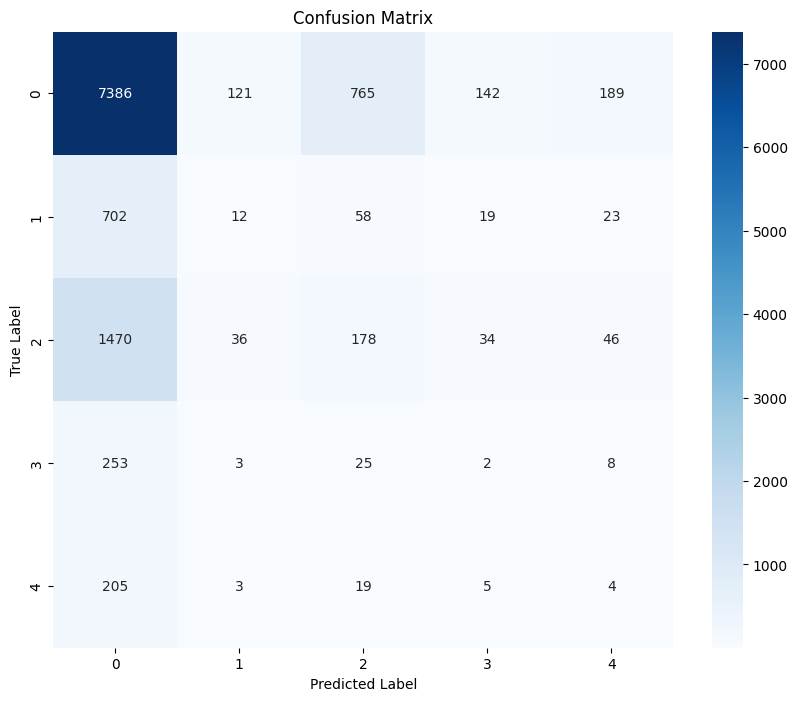

In [13]:
show_confusion_matrix(model)

In [14]:
_metrices = model.evaluate(test_generator)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

5854/5854 [==============================] - 161s 27ms/step - loss: 1.8689 - accuracy: 0.7788 - auc: 0.8998 - balanced_accuracy: 0.7788 - fscore: 0.7224 - precision: 0.7803 - recall: 0.7760
Test Metrices [1.8689318895339966, 0.7787837386131287, 0.8997917771339417, 0.7787837386131287, 0.7224027514457703, 0.7802971601486206, 0.77596515417099]
